
# Poisson problem

Let us solve the Poisson problem of finding $u$ satisfying 

$$
\begin{aligned}
-\Delta u + u& = f && \text { in  } (0,10)^2,
\\
\frac{\partial u }{\partial n } & = 0 
&& \text{ on the boundary parts}.
\end{aligned}
$$

## Quick steps to solution:

#### 1. Import NGSolve and Netgen Python modules:

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw

#### 2. Main discretization parameters and mesh

In [2]:
order = 4
maxh = 0.5

from netgen.geom2d import SplineGeometry
geo = SplineGeometry()
geo.AddRectangle((0,0), (10,10), bcs=['bottom','right','top','left'])

mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.nv, mesh.ne

(499, 916)

#### 3. Reference solution and corresponding right hand side


In [3]:
ref_sol = exp(-2*((x-4)**2+(y-6)**2))
Draw(ref_sol, mesh, "reference solution")

refdx = ref_sol.Diff(x)
refdy = ref_sol.Diff(y)
rhs = -refdx.Diff(x)-refdy.Diff(y) + ref_sol

ref_sol_grad = CoefficientFunction( (refdx,refdy) )

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

#### 4. Declare a finite element space and gridfunction

In [4]:
fes = H1(mesh, order=order)# fe space
sol = GridFunction(fes)  # solution 
print(fes.ndof) # number of degrees of freedom

7489


#### 5. Define and assemble linear and bilinear forms

In [5]:
u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()   # symbolic object

a = BilinearForm(fes, symmetric=True)
a += (grad(u)*grad(v) + u*v)*dx
a.Assemble()

f = LinearForm(fes)
f += rhs*v*dx
f.Assemble()

#### 6. Solve system and draw solution

In [6]:
from time import time

t1 = time()
sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
print("time = ", time()-t1)
Draw(sol, mesh, "sol")

time =  0.17353224754333496


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

#### 7. Compute error

In [7]:
Draw(sqrt((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol))), mesh, 'error')
H1err = sqrt( Integrate((ref_sol-sol)**2 + InnerProduct(ref_sol_grad-Grad(sol),ref_sol_grad-Grad(sol)), mesh, VOL, 2*order) )
help(Integrate)
print(H1err)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

Help on built-in function Integrate in module ngsolve.comp:

Integrate(...) method of builtins.PyCapsule instance
    Integrate(*args, **kwargs)
    Overloaded function.
    
    1. Integrate(cf: ngsolve.fem.CoefficientFunction, mesh: Union[ngsolve.comp.Mesh, ngsolve.comp.Region], VOL_or_BND: ngsolve.comp.VorB = VorB.VOL, order: int = 5, definedon: ngsolve.comp.Region = None, region_wise: bool = False, element_wise: bool = False) -> object
    
    
    Parameters
    ----------
    
    cf: ngsolve.CoefficientFunction
      Function to be integrated. Can be vector valued, then the result is an array. If you want to integrate
      a lot of functions on the same domain, it will be faster to put them into a vector valued function,
      NGSolve will then be able to use parallelization and SIMD vectorization more efficiently.
    
    mesh: ngsolve.Mesh
      The mesh to be integrated on.
    
    VOL_or_BND: ngsolve.VorB = VOL
      Co-dimension to be integrated on. Historically this co

#### 8. Draw error plot - fixe Polynomordnung p

time = 0.016953229904174805
time = 0.005984306335449219
time = 0.02349567413330078
time = 0.09972405433654785
time = 0.46866297721862793

[0.45682032753337776, 0.14833301472741847, 0.030918058907279854, 0.007825169786146467, 0.00188933562922149]



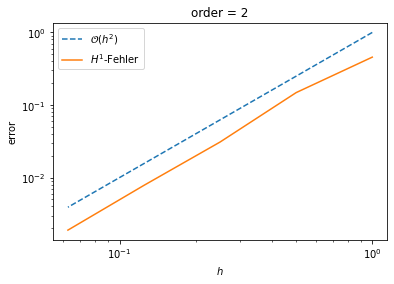

In [13]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

order = 2

i_max = 5
h_array = np.array([2 ** -i for i in range(i_max+1)])

error_array = []
for h in h_array:

    mesh = Mesh(geo.GenerateMesh(maxh = h))

    # fe space
    fes = H1(mesh, order=order)

    # solution
    sol = GridFunction(fes)

    # symbolic object
    u = fes.TrialFunction()
    v = fes.TestFunction()

    a = BilinearForm(fes, symmetric = True)
    a += (grad(u) * grad(v) + u * v) * dx
    a.Assemble()

    f = LinearForm(fes)
    f += rhs * v * dx
    f.Assemble()

    t1 = time()
    sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    print("time =", time()-t1)

    error_array.append(
        sqrt(
            Integrate(
                (ref_sol-sol) ** 2 + InnerProduct(ref_sol_grad - Grad(sol),
                ref_sol_grad - Grad(sol)
            ),
            mesh,
            VOL,
            2 * order)
        )
    )

print()

print(error_array)
print()

reference_array = h_array ** order

plt.plot(h_array, reference_array, label = '$' + r'\mathcal{O}' + f'(h^{order})' + '$', linestyle = 'dashed')
plt.plot(h_array, error_array,     label = '$H^1$-Fehler')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('$h$')
plt.ylabel('error')

plt.title(f'order = {order}')

plt.legend()

plt.show()

#### 9. Draw error plot - fixes Mesh


time =  0.0298769474029541
time =  0.1705479621887207
time =  0.4856376647949219
time =  0.9704270362854004
time =  1.6352319717407227

[0.126568419346477, 0.004813695290170682, 0.00013730940995843166, 3.474978551216211e-06, 7.836164898639933e-08]



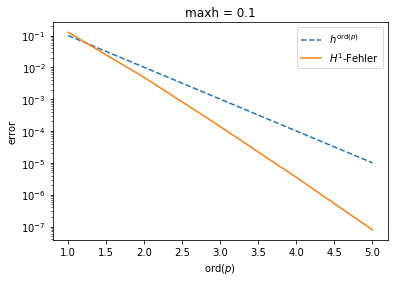

In [15]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

maxh = 0.1

mesh = Mesh(geo.GenerateMesh(maxh=maxh))

order_array = [x for x in range(1, 6)]

error_array = []
for order in order_array:
    
    # fe space
    fes = H1(mesh, order = order)

    # solution
    sol = GridFunction(fes)

    # symbolic objects
    u = fes.TrialFunction()
    v = fes.TestFunction()

    a = BilinearForm(fes, symmetric=True)
    a += (grad(u) * grad(v) + u * v) * dx
    a.Assemble()

    f = LinearForm(fes)
    f += rhs * v * dx
    f.Assemble()

    t1 = time()
    sol.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec
    print("time =", time()-t1)

    error_array.append(
        sqrt(
            Integrate(
                (ref_sol - sol) ** 2 + InnerProduct(
                    ref_sol_grad - Grad(sol),
                    ref_sol_grad - Grad(sol)
                    ),
                mesh,
                VOL,
                2 * order
            )
        )
    )

print()

print(error_array)
print()

reference_array = [maxh**(x) for x in order_array]

plt.plot(order_array, reference_array, label = r"$h^{\mathrm{ord}(p)}$", linestyle = 'dashed',)
plt.plot(order_array, error_array,     label = "$H^1$-Fehler")

plt.yscale('log')

plt.xlabel(r'$\mathrm{ord}(p)$')
plt.ylabel("error")

plt.legend()

plt.title(f"maxh = {maxh}")

plt.show()